In [79]:
import pandas as pd
import numpy as np
import os


In [80]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train.pkl")
X_val = pd.read_pickle("../../data/interim/X_val.pkl")
X_test = pd.read_pickle("../../data/interim/X_test.pkl")
y_train = pd.read_pickle("../../data/interim/y_train.pkl")
y_val = pd.read_pickle("../../data/interim/y_val.pkl")
y_test = pd.read_pickle("../../data/interim/y_test.pkl")

In [81]:
'''
# collapse BSC, FKL, SDL, FOL into FALL
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']

y_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')
y_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')
y_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')

'''

"\n# collapse BSC, FKL, SDL, FOL into FALL\nfall_labels = ['BSC', 'FKL', 'SDL', 'FOL']\n\ny_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')\ny_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')\ny_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')\n\n"

In [82]:
y_train.unique()

array(['STD', 'WAL', 'LYI', 'STN', 'CSI', 'SIT', 'CSO', 'STU', 'FKL',
       'SCH', 'BSC', 'CHU', 'SDL', 'JUM', 'JOG', 'FOL'], dtype=object)

### Segment into Windows

In [83]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(X, y, window_size=100, step_size=50):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [84]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [85]:
X_train_windows.shape

(55629, 100, 6)

### Encode Label

In [86]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout
)


# X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # ⇒ (100, 6)
num_classes  = len(set(y_train_windows_encoded))                    # e.g. 13 activities

model_fd_dnn = Sequential([
    # C1: 1D‐Conv k=3, 32 filters → S1: pool 2
    Conv1D(32, kernel_size=3, activation='relu', padding='same',
           input_shape=input_shape),
    MaxPooling1D(pool_size=2, strides=2),

    # C2: 1D‐Conv k=5, 64 filters → S2: pool 2
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, strides=2),

    # C3: 1D‐Conv k=7, 128 filters → S3: pool 2
    Conv1D(128, kernel_size=7, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, strides=2),

    # C4: 1D‐Conv k=9, 200 filters → S4: pool 2
    Conv1D(200, kernel_size=9, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, strides=2),

    # At this point, time‐steps = 100 → 50 → 25 → 12 → 6
    # LSTM stack: first returns full sequence, second collapses to vector
    LSTM(200, return_sequences=True),
    LSTM(200),

    # Optional dense & dropout for extra regularization
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Final softmax over your activity classes
    Dense(num_classes, activation='softmax')
])

model_fd_dnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_fd_dnn.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 100, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 50, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 25, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 12, 200)        │       230,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 6, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 6, 200)         │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,488 (3.64 MB)

 Trainable params: 954,488 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history = model_fd_dnn.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.6807 - loss: 1.0386 - val_accuracy: 0.7611 - val_loss: 0.8244
Epoch 2/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.8710 - loss: 0.3810 - val_accuracy: 0.7995 - val_loss: 0.6082
Epoch 3/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.8957 - loss: 0.3051 - val_accuracy: 0.8484 - val_loss: 0.4320
Epoch 4/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9083 - loss: 0.2613 - val_accuracy: 0.7651 - val_loss: 0.6468
Epoch 5/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9161 - loss: 0.2307 - val_accuracy: 0.7974 - val_loss: 0.5574
Epoch 6/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9271 - loss: 0.2096 - val_accuracy: 0.8505 - val_loss: 0.4517
Epoch 7/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9319 - loss: 0.1896 - val_accuracy: 0.7796 - val_loss: 0.9782
Epoch 8/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9357 -

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 1.3068
Test Accuracy: 0.8071
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


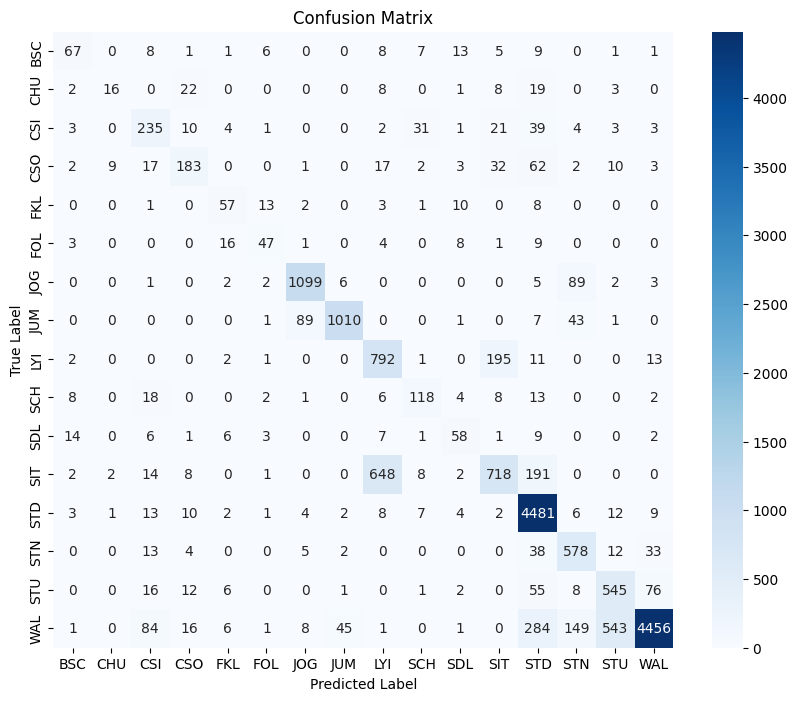

Classification Report:
               precision    recall  f1-score   support

         BSC       0.63      0.53      0.57       127
         CHU       0.57      0.20      0.30        79
         CSI       0.55      0.66      0.60       357
         CSO       0.69      0.53      0.60       343
         FKL       0.56      0.60      0.58        95
         FOL       0.59      0.53      0.56        89
         JOG       0.91      0.91      0.91      1209
         JUM       0.95      0.88      0.91      1152
         LYI       0.53      0.78      0.63      1017
         SCH       0.67      0.66      0.66       180
         SDL       0.54      0.54      0.54       108
         SIT       0.72      0.45      0.56      1594
         STD       0.86      0.98      0.91      4565
         STN       0.66      0.84      0.74       685
         STU       0.48      0.75      0.59       722
         WAL       0.97      0.80      0.87      5595

    accuracy                           0.81     17917
  

In [ ]:
label_classes = le.classes_.tolist()
metrics = evaluate_model(model_fd_dnn, X_test_windows, y_test_windows_encoded, label_classes=label_classes)

### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model_cnn_lstm = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        # The LSTM layer now interprets the feature maps temporally.
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
])

    model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    return model_cnn_lstm

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
